In [250]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error



In [254]:
# read data
df = pd.read_csv('data/training_jumlah_penumpang_tj.csv', sep=';')

jlh_armada_tj = pd.read_csv('data/jumlah_armada_tj.csv', sep=';')
jlh_penumpang_lrt = pd.read_csv('data/jumlah_penumpang_lrt.csv', sep=';')
jlh_penumpang_mrt = pd.read_csv('data/jumlah_penumpang_mrt.csv', sep=';')
jlh_perjalanan_lrt = pd.read_csv('data/jumlah_perjalanan_lrt.csv', sep=';')
jlh_perjalanan_mrt = pd.read_csv('data/jumlah_perjalanan_mrt.csv', sep=';')


In [255]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   bulan             108 non-null    int64
 1   tahun             108 non-null    int64
 2   jumlah_penumpang  108 non-null    int64
dtypes: int64(3)
memory usage: 2.7 KB


In [256]:
def add_date_column(data, year_col_name, month_col_name, day_col_name):
    data['year'] = data[year_col_name]
    data['month'] = data[month_col_name]
    data['day'] = data[day_col_name]
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

    return data

In [257]:
df = df.assign(hari=1)
df = add_date_column(df, 'tahun', 'bulan', 'hari')
df['date'] = pd.to_datetime(df['date'])
df.head()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,date
0,1,2015,8738599,1,2015,1,1,2015-01-01
1,2,2015,7630313,1,2015,2,1,2015-02-01
2,3,2015,9383835,1,2015,3,1,2015-03-01
3,4,2015,8832441,1,2015,4,1,2015-04-01
4,5,2015,9035420,1,2015,5,1,2015-05-01


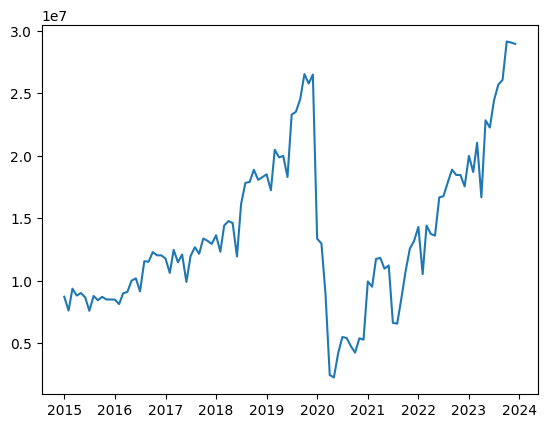

In [258]:
plt.plot(df['date'], df['jumlah_penumpang'])


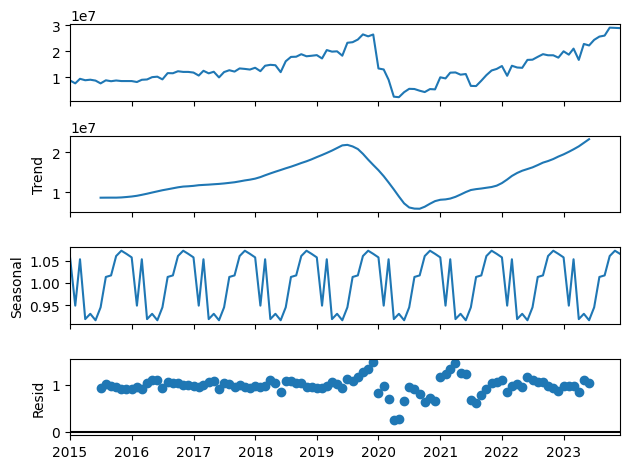

In [259]:
# cek seasonality, trend dan residual
df_analysis = df[:]
df_analysis.set_index('date', inplace=True)
analysis = df_analysis[['jumlah_penumpang']].copy()

# multiplicative is selected because there's increasing mean and seasonality
decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();


- there's anomaly in early 2020, which we know as covid pandemic. we try to use dummy variable to take account this phenomenon by assigning 1 if the periods is in covid era and 0 if it's not.
- there's maybe a seasonality pattern where the number of passengers dropped to lowest in mid year. we know that in mid year there's a long holiday (libur semester), and when there's long holiday, jakarta's people usually goes to holiday outside the city so the passenger in this period is dropped.
- The data has changing mean, meaning it is non stationary time series case.
- Because we use dummy variable as exogenouse variable, we need to use model that can handle exogenous case.

In [260]:
covid_start = datetime(2020, 3, 1) #'2020-03-01'
covid_end = datetime(2023, 5, 1) #'2023-05-01'
seasonality_lag = 6

In [261]:
def add_dummy_covid(row, covid_start, covid_end):
    if row['date'] < covid_start or row['date'] > covid_end :
        val = 0
    else:
        val = 1
    return val

In [262]:
df['covid_dummy'] = df.apply(lambda x: add_dummy_covid(x, covid_start, covid_end), axis=1)

In [263]:
# data before we doesn't have covid
df[(df['date'] < covid_start) | (df['date']  > covid_end)]

,bulan,tahun,jumlah_penumpang,hari,year,month,day,date,covid_dummy
0,1,2015,8738599,1,2015,1,1,2015-01-01,0
1,2,2015,7630313,1,2015,2,1,2015-02-01,0
2,3,2015,9383835,1,2015,3,1,2015-03-01,0
3,4,2015,8832441,1,2015,4,1,2015-04-01,0
4,5,2015,9035420,1,2015,5,1,2015-05-01,0
...,...,...,...,...,...,...,...,...,...
103,8,2023,25693459,1,2023,8,1,2023-08-01,0
104,9,2023,26076085,1,2023,9,1,2023-09-01,0
105,10,2023,29146729,1,2023,10,1,2023-10-01,0
106,11,2023,29062581,1,2023,11,1,2023-11-01,0


In [264]:
# data when we have covid
df[(df['date'] >= covid_start) & (df['date']  <= covid_end)].head()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,date,covid_dummy
62,3,2020,9015000,1,2020,3,1,2020-03-01,1
63,4,2020,2481000,1,2020,4,1,2020-04-01,1
64,5,2020,2282000,1,2020,5,1,2020-05-01,1
65,6,2020,4228000,1,2020,6,1,2020-06-01,1
66,7,2020,5515000,1,2020,7,1,2020-07-01,1


In [265]:
# split data
df_train_test = df.copy()
df_train_test.set_index('date', inplace=True)
test_split=round(len(df)*0.04)
df_train=df_train_test[:-test_split]
df_test=df_train_test[-test_split:]
print(df_train.shape)
print(df_test.shape)

(104, 8)
(4, 8)


In [266]:
df_train.tail()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,covid_dummy
date,,,,,,,,
2023-04-01,4,2023,16686971,1,2023,4,1,1
2023-05-01,5,2023,22845144,1,2023,5,1,1
2023-06-01,6,2023,22264954,1,2023,6,1,0
2023-07-01,7,2023,24428349,1,2023,7,1,0
2023-08-01,8,2023,25693459,1,2023,8,1,0


In [267]:

model = SARIMAX(df_train['jumlah_penumpang'], exog=df_train[['covid_dummy']], order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonality_lag))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51584D+01    |proj g|=  4.96897D-02

At iterate    5    f=  1.51413D+01    |proj g|=  1.46717D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8      9      1     0     0   3.545D-05   1.514D+01
  F =   15.141298026392889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                  jumlah_pen

/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [275]:
df_train_test['fitted'] = model_fit.fittedvalues


<Axes: xlabel='date'>

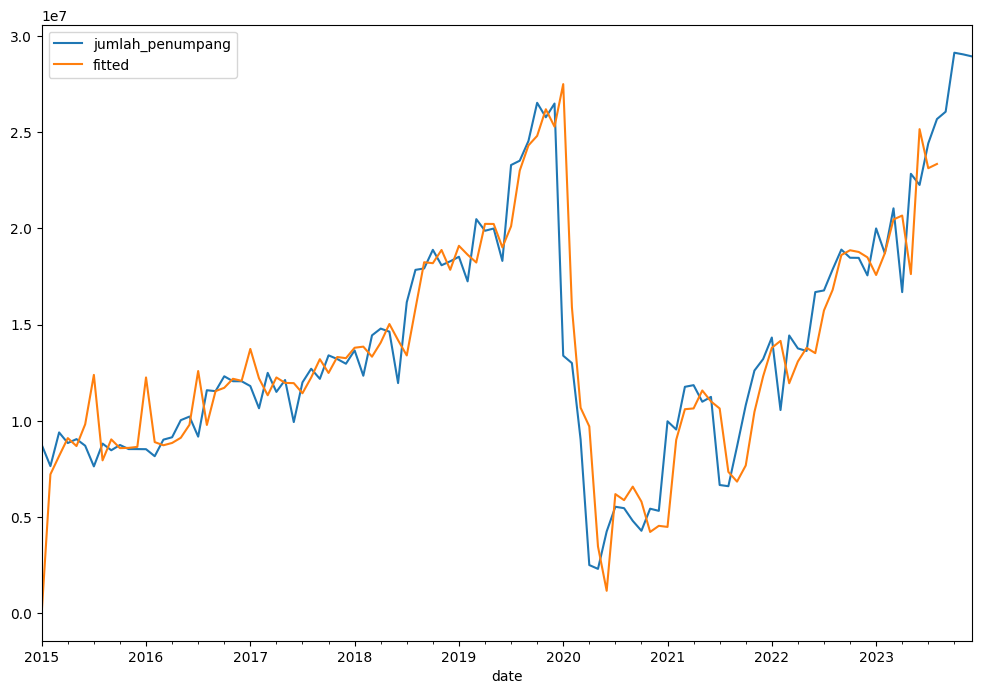

In [276]:
df_train_test[['jumlah_penumpang', 'fitted']].plot(figsize=(12, 8))

In [270]:
df_train.tail()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,covid_dummy,fitted
date,,,,,,,,,
2023-04-01,4,2023,16686971,1,2023,4,1,1,2.067145e+07
2023-05-01,5,2023,22845144,1,2023,5,1,1,1.762507e+07
2023-06-01,6,2023,22264954,1,2023,6,1,0,2.516824e+07
2023-07-01,7,2023,24428349,1,2023,7,1,0,2.313617e+07
2023-08-01,8,2023,25693459,1,2023,8,1,0,2.335725e+07


Timestamp('2023-12-01 00:00:00')

/var/folders/c1/h3nnk0c16j75s9z5w3kz92cw0000gn/T/ipykernel_32398/3218250320.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df_test.index[-1], periods=forecast_steps + 1, freq='M')[1:]


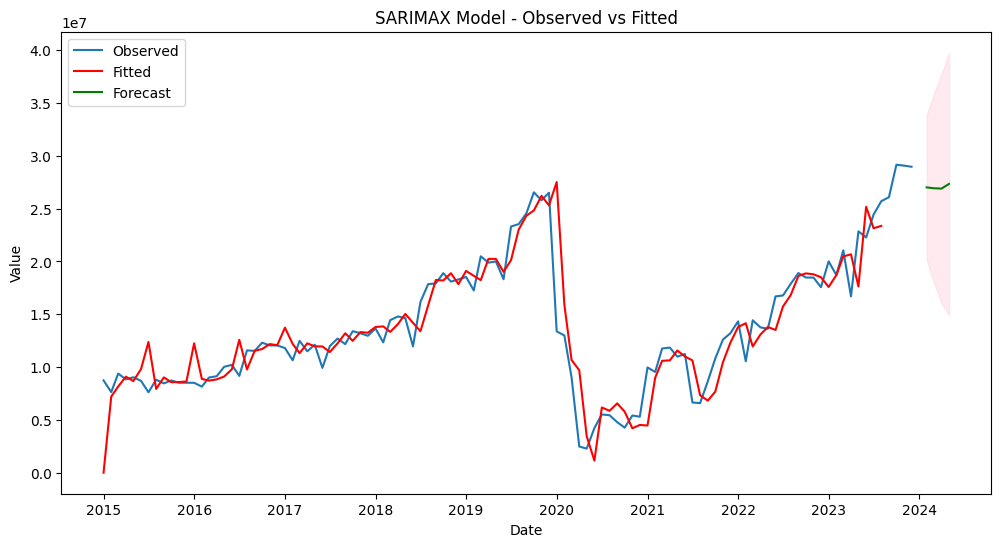

In [277]:
forecast_steps = test_split
forecast = model_fit.get_forecast(steps=forecast_steps, exog=df_test[['covid_dummy']])
forecast_index = pd.date_range(start=df_test.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Extract predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

df_train_test

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_train_test.index, df_train_test['jumlah_penumpang'], label='Observed')
plt.plot(df_train_test.index, df_train_test['fitted'], color='red', label='Fitted')
plt.plot(forecast_index, forecast_mean, color='green', label='Forecast')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Model - Observed vs Fitted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

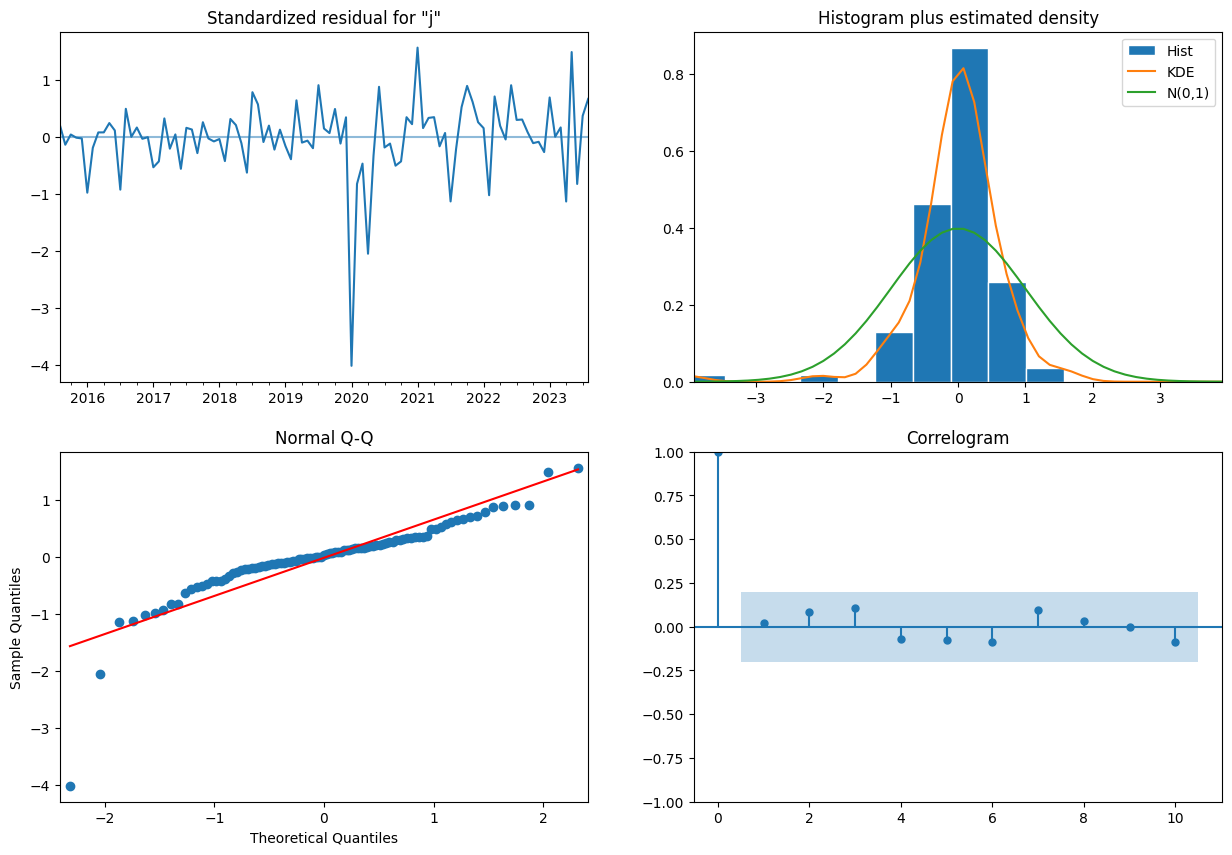

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(df_train['jumlah_penumpang'], df_train['fitted']))
rmse

2487905.3111186707

In [282]:
rmse = np.sqrt(mean_squared_error(df_test['jumlah_penumpang'], forecast_mean))
rmse

1814528.4378128434

In [283]:
model = SARIMAX(df_train_test['jumlah_penumpang'], exog=df_train_test[['covid_dummy']], order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonality_lag))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52006D+01    |proj g|=  4.47677D-02

At iterate    5    f=  1.51850D+01    |proj g|=  1.25035D-03

At iterate   10    f=  1.51849D+01    |proj g|=  2.26272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   7.010D-07   1.518D+01
  F =   15.184922747812729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [285]:
df_submission = pd.read_csv('data/testing_jumlah_penumpang_tj.csv', sep=';')
df_submission['covid_dummy'] = 0
# forecast_steps = test_split
# forecast = model_fit.get_forecast(steps=forecast_steps, exog=df_test[['covid_dummy']])